<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [33]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [34]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-05-08 22:33:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2021-05-08 22:33:46 (12.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [35]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [36]:
df.shape

(346, 10)

### Convert to date time object 

In [37]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [38]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [39]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

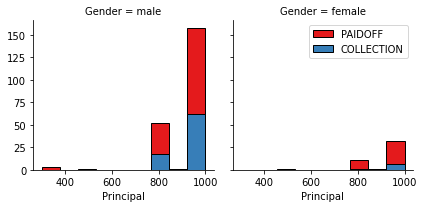

In [40]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

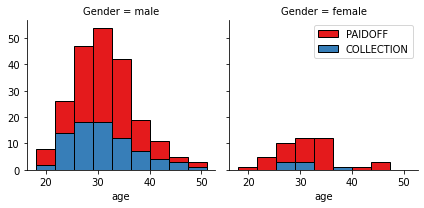

In [41]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

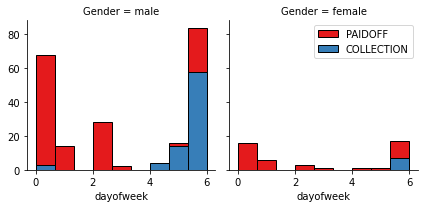

In [42]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [43]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [44]:
df.education.unique()

array(['High School or Below', 'Bechalor', 'college', 'Master or Above'],
      dtype=object)

In [45]:
df.loan_status.unique()

array(['PAIDOFF', 'COLLECTION'], dtype=object)

## Convert Categorical features to numerical values

Lets look at gender:

In [46]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [47]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [48]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [49]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [50]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [51]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [52]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [53]:
y1=df[['loan_status']]
#y1=pd.get_dummies(y1, columns=["loan_status"])
y1['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [54]:
y1=y1['loan_status']


In [55]:
y1

0      0
1      0
2      0
3      0
4      0
      ..
341    1
342    1
343    1
344    1
345    1
Name: loan_status, Length: 346, dtype: int64

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [56]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import log_loss

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [205]:
## Create the training and test set for KNN
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ("Training set :", X_train.shape, Y_train.shape)
print ("Test set :", X_test.shape, Y_test.shape)

Training set : (276, 8) (276,)
Test set : (70, 8) (70,)


In [206]:
## Check whicj K value is suitable best for the model accuracy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

K = 30
mean_acc=np.zeros((K-1))
std_acc=np.zeros((K-1))
ConfusionMat=[];

for i in range (1,K):
    neigh=KNeighborsClassifier(n_neighbors=i).fit(X_train, Y_train)
    yhat=neigh.predict(X_test)
    mean_acc[i-1]=accuracy_score(Y_test, yhat)
    std_acc[i-1]=np.std(yhat==Y_test)/np.sqrt(yhat.shape[0])
    



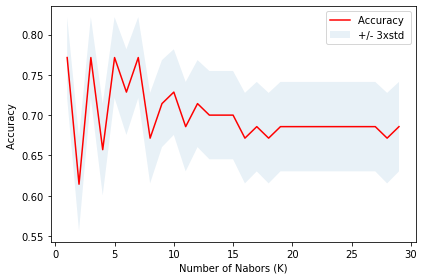

In [207]:
## Plot the results to find which K value gives better accuracy
plt.plot(range(1,K), mean_acc,'r')
plt.fill_between(range(1,K),mean_acc-1*std_acc,mean_acc+1*std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [208]:
## Print the suitable k value for our model
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7714285714285715 with k= 1


### KNN model with K $=$ 1 from the previous analysis

In [209]:
from sklearn.neighbors import KNeighborsClassifier
K=1
model_KNN=KNeighborsClassifier(n_neighbors=K).fit(X_train, Y_train)
yhat=model_KNN.predict(X_test)

### Calculate f1 score and Jaccard score besed on my model

In [195]:
print ('f1_score ', f1_score(Y_test, yhat, average='weighted') )
print('jaccard_score ', jaccard_score(Y_test, yhat,pos_label='PAIDOFF'))

f1_score  0.7766540244416351
jaccard_score  0.765625


# Decision Tree

In [211]:
## Create the training and test set for KNN
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ("Training set :", X_train.shape, Y_train.shape)
print ("Test set :", X_test.shape, Y_test.shape)

Training set : (276, 8) (276,)
Test set : (70, 8) (70,)


In [212]:
from sklearn.tree import DecisionTreeClassifier
Model_Decision_tree=DecisionTreeClassifier(criterion="entropy", max_depth=None)
Model_Decision_tree.fit(X_train,Y_train)
Pred_tree=Model_Decision_tree.predict(X_test)

In [213]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(Y_test, Pred_tree))

DecisionTrees's Accuracy:  0.6714285714285714


### Calculate f1 score and Jaccard score besed on my model

In [214]:
print ('f1_score ', f1_score(Y_test, Pred_tree, average='weighted') )
print('jaccard_score ', jaccard_score(Y_test, Pred_tree,pos_label='PAIDOFF'))

f1_score  0.6970348989766466
jaccard_score  0.6349206349206349


# Support Vector Machine

In [216]:
## Create the training and test set for KNN
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ("Training set :", X_train.shape, Y_train.shape)
print ("Test set :", X_test.shape, Y_test.shape)

Training set : (276, 8) (276,)
Test set : (70, 8) (70,)


In [217]:
from sklearn import svm
Model_SVM=svm.SVC(kernel='rbf', class_weight=None)
Model_SVM.fit(X_train,Y_train)

yhat=Model_SVM.predict(X_test)

### Calculate f1 score and Jaccard score besed on my model

In [218]:
print ('f1_score ', f1_score(Y_test, yhat, average='weighted') )

print('jaccard_score ', jaccard_score(Y_test, yhat,pos_label='PAIDOFF'))

f1_score  0.6763832658569502
jaccard_score  0.6764705882352942


# Logistic Regression

In [239]:
## Create the training and test set for KNN
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ("Training set :", X_train.shape, Y_train.shape)
print ("Test set :", X_test.shape, Y_test.shape)

Training set : (276, 8) (276,)
Test set : (70, 8) (70,)


In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
Model_LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
Model_LR

LogisticRegression(C=0.01, solver='liblinear')

In [241]:
yhat = Model_LR.predict(X_test)
yhat_prob = Model_LR.predict_proba(X_test)


### calculate F1 score, Jaccard index and log loss

In [242]:
print ('f1_score ', f1_score(Y_test, yhat, average='weighted') )
print('jaccard_score ', jaccard_score(Y_test, yhat,pos_label='PAIDOFF'))
print ('Log_loss', log_loss(Y_test,yhat_prob))

f1_score  0.695771878072763
jaccard_score  0.6865671641791045
Log_loss 0.5773412252583207


# Model Evaluation using Test set

First, download and load the test set:

In [111]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-05-08 22:58:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-05-08 22:58:03 (109 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [112]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [113]:
test_df.shape

(54, 10)

In [114]:
## convert date-time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [115]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

In [116]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [117]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [118]:
test_df.shape

(54, 12)

In [119]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [120]:
test_Feature.shape

(54, 8)

In [133]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [134]:
test_X = test_Feature
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_Y = test_df['loan_status'].values

In [135]:
test_X.shape

(54, 8)

In [136]:
test_Y.shape

(54,)

## Testing my models with the given data set 

#### Using KNN model

In [245]:
## Algorithm: KNN
yhat_KNN = model_KNN.predict(test_X)

f1_KNN=f1_score(test_Y, yhat_KNN, average='weighted')
JS_KNN=jaccard_score(test_Y, yhat_KNN,pos_label='PAIDOFF')

print ("f1_score(KNN)  %.3f" % f1_KNN )
print('jaccard_score(KNN) %.3f' % JS_KNN)


f1_score(KNN)  0.749
jaccard_score(KNN) 0.729


#### Using Decision Tree model

In [246]:
## Decision tree
Pred_tree=Model_Decision_tree.predict(test_X)

f1_DT=f1_score(test_Y, Pred_tree, average='weighted')
JS_DT=jaccard_score(test_Y, Pred_tree,pos_label='PAIDOFF')

print ("f1_score(DT)  %.3f" % f1_DT )
print('jaccard_score(DT) %.3f' % JS_DT)

f1_score(DT)  0.719
jaccard_score(DT) 0.688


#### Using SVM model

In [247]:
## Algorithm: SVM
yhat_SVM=Model_SVM.predict(test_X)

f1_SVM=f1_score(test_Y, yhat_SVM, average='weighted')
JS_SVM=jaccard_score(test_Y, yhat_SVM,pos_label='PAIDOFF')

print ("f1_score(SVM)  %.3f" % f1_SVM )
print('jaccard_score(SVM) %.3f' % JS_SVM)

f1_score(SVM)  0.729
jaccard_score(SVM) 0.740


#### Using Logistic Regression model

In [248]:
##nAlgorithm : Logistic Regression

yhat_LR = Model_LR.predict(test_X)
yhat_prob_LR = Model_LR.predict_proba(test_X)

f1_LR=f1_score(test_Y, yhat_LR, average='weighted') 
JS_LR=jaccard_score(test_Y, yhat_LR,pos_label='PAIDOFF')
LS_LR=log_loss(test_Y,yhat_prob_LR)

print ('f1_score %.3f' % f1_LR)
print('jaccard_score %.3f' % JS_LR)
print ('Log_loss %3f' % LS_LR)


f1_score 0.743
jaccard_score 0.760
Log_loss 0.564030


## Report 

In [271]:
print ('{:<20s}{:>12s}{:>12s}{:>12s}' .format('Algorithm', 'Jaccard', 'F1-score', 'LogLoss'))
print('-' * 57)
print('{:<20s}{:>12.3f}{:>12.3f}{:>12s}' .format('KNN',JS_KNN, f1_KNN, 'NA'))
print('{:<20s}{:>12.3f}{:>12.3f}{:>12s}' .format('Decision Tree',JS_DT, f1_DT, 'NA'))
print('{:<20s}{:>12.3f}{:>12.3f}{:>12s}' .format('SVM',JS_SVM, f1_SVM, 'NA'))
print('{:<20s}{:>12.3f}{:>12.3f}{:>12.3f}' .format('LogisticRegression',JS_LR, f1_LR, LS_LR))

Algorithm                Jaccard    F1-score     LogLoss
---------------------------------------------------------
KNN                        0.729       0.749          NA
Decision Tree              0.688       0.719          NA
SVM                        0.740       0.729          NA
LogisticRegression         0.760       0.743       0.564


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>